# CAPSNET Monitor

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
HTML(
'''<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>''')


In [3]:
#%reload_ext watermark
#%watermark
%matplotlib notebook
#%matplotlib  widget
#%matplotlib inline

import os
os.chdir('/home/jens/eclipse-workspace/MatrixCaps/Matrix-Capsule-Network/')

import torch
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch.nn.functional as F
from model import capsules as mcaps
import matplotlib
import numpy as np
import time

import ipywidgets as widgets
from ipywidgets import FloatSlider, HBox, VBox
matplotlib.pyplot.ioff()

import glob
from IPython.display import display, Markdown

## Matrix Capsules LOSS plot

<IPython.core.display.Javascript object>


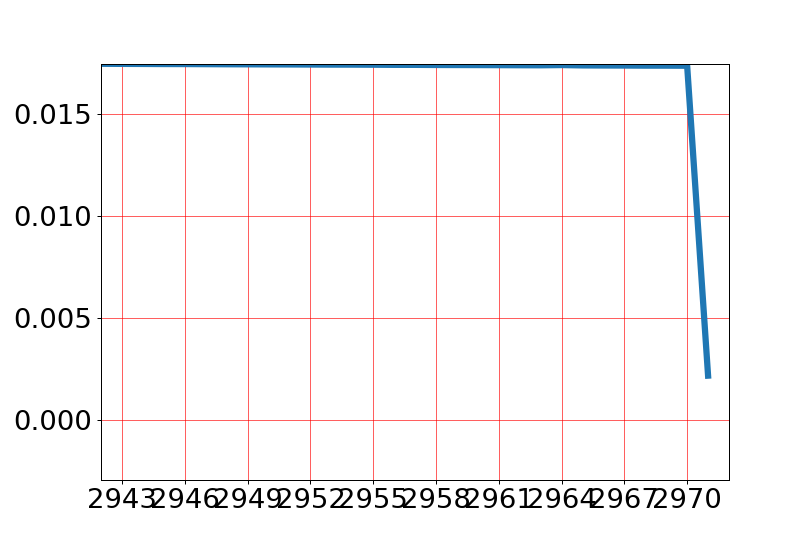

Button(description='Update', style=ButtonStyle())

IntText(value=30, description='Epoch history')

In [4]:
matplotlib.rcParams.update({'font.size': 22})
fig3 = matplotlib.pyplot.figure(figsize = (9,6))
ax3 = fig3.subplots()
matplotlib.pyplot.ion()


button = widgets.Button(description="Update")
show_epochs = widgets.IntText(description='Epoch history',disabled=False)
show_epochs.value = 30

def on_button_clicked(b):
    with open('loss.log') as f:
        content = f.readlines()
    content = [float(x.strip()) for x in content]
    xmin = 0
    xmax = len(content)
    if xmax > show_epochs.value:
        xmin = xmax-show_epochs.value
        content = content[xmin:xmax]
    ymin = np.min(content)
    ymax = np.max(content)
    x_axis = np.linspace(xmin, xmax-1, num=xmax-xmin)

    #matplotlib.pyplot.gcf().clear()
    ax3.clear()
    ax3.set_xlim(xmin, xmax)
    yaxismin = ymin - (ymax-ymin)/3
    if yaxismin < 0:
        yaxismin = 0
    ax3.set_ylim(ymin - (ymax-ymin)/3, ymax)
    ax3.plot(x_axis, content, linewidth=5.0)
    ax3.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax3.grid(linestyle='-', linewidth='0.5', color='red')
    fig3.canvas.draw()

    
on_button_clicked(None)
fig3.show()

display(button)
display(show_epochs)

button.on_click(on_button_clicked)
show_epochs.observe(on_button_clicked)

In [5]:
class args():
    num_classes = 1
    batch_size = 1
    routing = 'EM_routing'
    loss = 'spread_loss̈́'
    use_recon = 0.001
    r = 3
    num_workers = 1
    disable_encoder = False
    disable_recon = False

A, AA, B, C, D, E, r = 32, 64, 16, 16, 16, args.num_classes, args.r # a small CapsNet

model = mcaps.CapsNet(args, A, AA, B, C, D, E, r, h=4)

LatestFile = max(glob.iglob("./weights/em_capsules/model*.pth"),key=os.path.getctime)

display(Markdown('## Latest model is: '+LatestFile))

model.load_state_dict(torch.load(LatestFile))
model.cpu()

self = model

## Latest model is: ./weights/em_capsules/model_6.pth

## Ground Truth

In [6]:
from main import MyImageFolder
train_dataset = MyImageFolder(root='../../data/dumps/', transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=args.batch_size,num_workers=args.num_workers,shuffle=False)

<IPython.core.display.Javascript object>


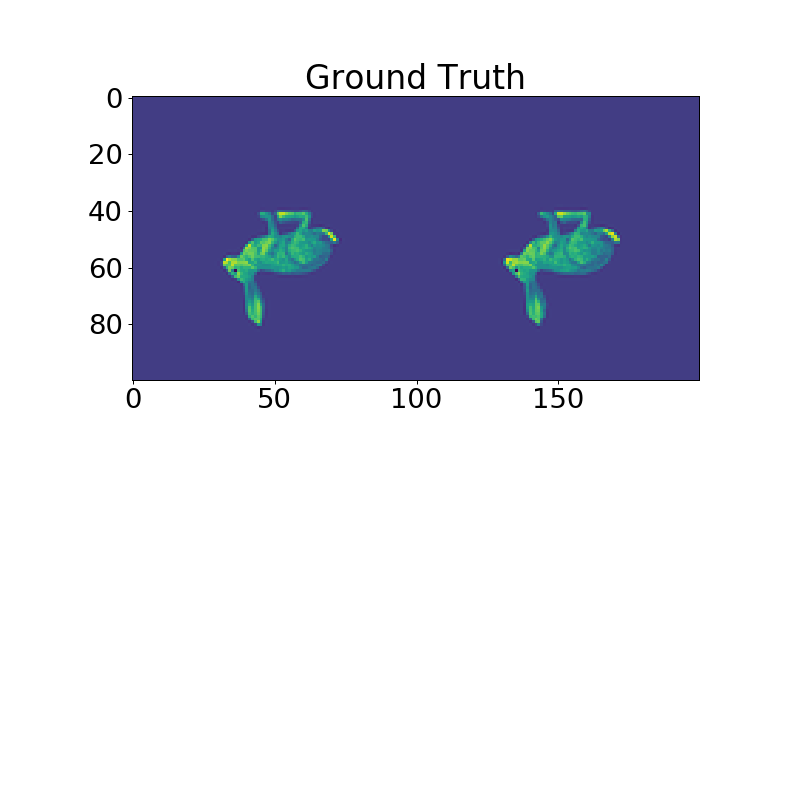

In [7]:
def gaussian(ins, is_training, mean, stddev):
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
        return ins + noise
    return ins

lambda_ = 1.0

data_iter = iter(train_loader)

def getImage(img_data):
    imgs = img_data
    imgs = imgs[:,0,:,:].unsqueeze(1) # use only red channel
    left = imgs[:,:,:,:int(imgs.shape[-1]/2)]
    right = imgs[:,:,:,int(imgs.shape[-1]/2):]
    imgs_two_channel_red = np.stack([left[:,0,:,:],right[:,0,:,:]], axis=1)
    return imgs_two_channel_red

data = next(data_iter)
imgs, ground_truth_labels = data
imgs = imgs[:,0,:,:].unsqueeze(1) # use only red channel

fig = matplotlib.pyplot.figure(figsize = (9,9))
ax = fig.add_subplot(2,1,1)
ax.set_title('Ground Truth')
ax.imshow(imgs.squeeze())#, cmap='Greys',  interpolation='nearest')
"""ax1 = fig.add_subplot(2,1,2)
ax1.set_title('Ground Truth')
imgs = gaussian(imgs, True, 0.0, 0.1)
ax1.imshow(imgs.squeeze())#, cmap='Greys',  interpolation='nearest')"""
#matplotlib.pyplot.show()
fig.show()
fig.canvas.draw()

imgs = getImage(data[0])

imgs = Variable(torch.from_numpy(imgs)).cpu()

In [8]:
def makeCombinedImage(img):
    img = img.squeeze().unsqueeze(1)
    return utils.make_grid(img.data, nrow=int(img.shape[0] ** 0.5), normalize=True,range=(0, 1)).cpu().numpy()
    
def forward(self, x, lambda_, labels=None, draw=True):
    if x is not None:
        x = F.relu(self.conv1(x))  # b,32,12,12

        if draw is True:
            fig = matplotlib.pyplot.figure(figsize = (8,8))
            ax1 = fig.add_subplot(1,1,1)
            grid_picture = makeCombinedImage(x)
            ax1.imshow(grid_picture.transpose(1,2,0))
            ax1.set_title('layer 1')

        x = F.max_pool2d(x, 2, 2, 1)
        x = F.relu(self.conv2(x))
        
        if draw is True:
            figA = matplotlib.pyplot.figure(figsize = (8,8))
            axA = figA.add_subplot(1,1,1)
            grid_picture = makeCombinedImage(x)
            axA.imshow(grid_picture.transpose(1,2,0))
            axA.set_title('layer 2')
        
        x = self.primary_caps(x)  # b,32*(4*4+1),12,12

        if draw is True:
            figB = matplotlib.pyplot.figure(figsize = (8,8))
            axB = figB.add_subplot(1,1,1)

            grid_picture = makeCombinedImage(x[0])
            axB.imshow(grid_picture.transpose(1,2,0))
            axB.set_title('layer 3')

            matplotlib.pyplot.show()
            
        x = self.convcaps1(x, lambda_)  # b,32*(4*4+1),5,5
        x = self.convcaps2(x, lambda_)  # b,32*(4*4+1),3,3
        p, a = self.classcaps(x, lambda_)  # b,10*16+10

        p = p.squeeze()

        # Temporary when batch size = 1
        if len(p.shape) == 1:
            p = p.unsqueeze(0)
    else:
        p = labels

    if not self.args.disable_recon:
        reconstructions = self.decoder(p)
    else:
        reconstructions = 0

    return p, reconstructions

## Activations of convolutional layers and primary capsules layer

<IPython.core.display.Javascript object>


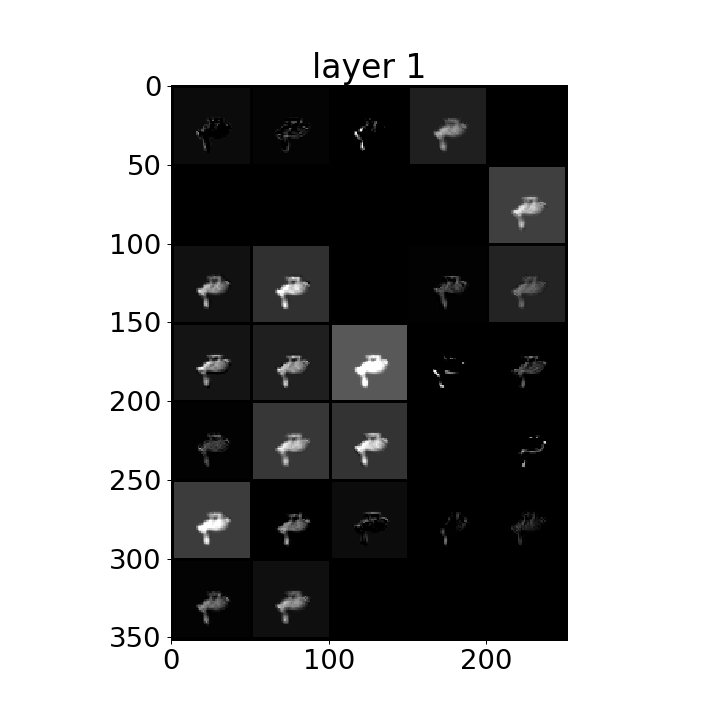

<IPython.core.display.Javascript object>


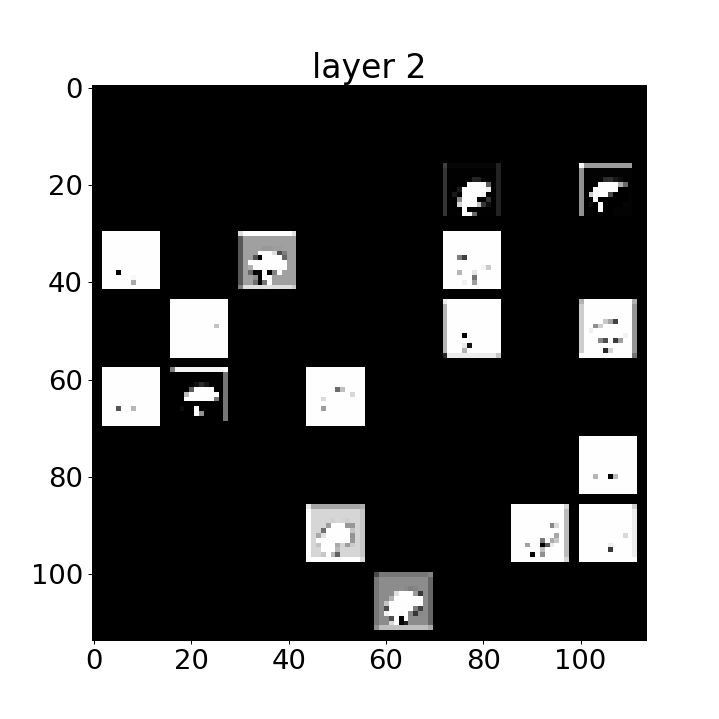

<IPython.core.display.Javascript object>


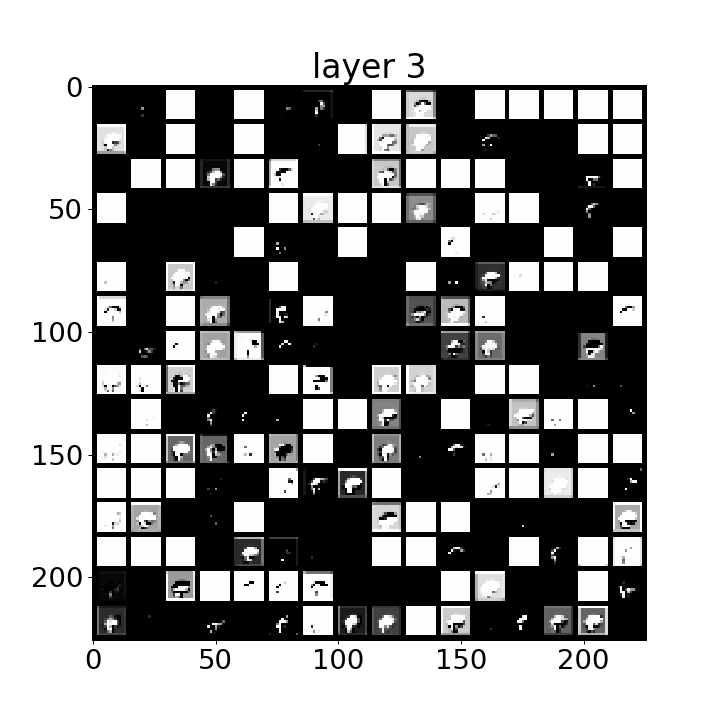

In [9]:
pose, reconstruction = forward(self, imgs, lambda_)

## 4x4 pose output

<IPython.core.display.Javascript object>


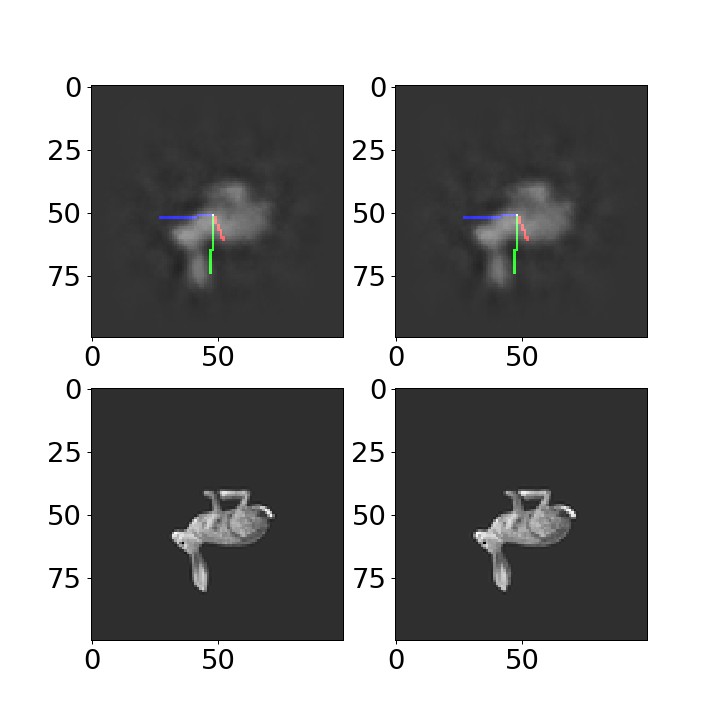

Text(value='', description='Pose output', layout=Layout(width='100%'))

Text(value='', description='Pose label', layout=Layout(width='100%'))

In [10]:
button_next = widgets.Button(description="Next")
names = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15']
pose_sliders = [FloatSlider(min=0, max=0, step=0.00001, description=i, orientation='vertical') for i in names]
vbox = VBox( [button_next, HBox(pose_sliders[0:16])] ) # :9
fig = matplotlib.pyplot.figure(figsize = (8,8))
ax_left = fig.add_subplot(2,2,1)
ax_left.set_title('Recon left')
ax_right = fig.add_subplot(2,2,2)
ax_right.set_title('Recon right')
ax_truth_l = fig.add_subplot(2,2,3)
ax_truth_l.set_title('ground truth')
ax_truth_r = fig.add_subplot(2,2,4)
ax_truth_r.set_title('ground truth')
pose_output = widgets.Text(layout={'width': '100%'},description='Pose output',disabled=False)
pose_label = widgets.Text(layout={'width': '100%'},description='Pose label',disabled=False)
the_time = time.time()

display(vbox)
display(pose_output)
display(pose_label)


# Initialize Transform Network (from Pose to Quaternion)
import sys
import pyrr
sys.path.append('../PoseToQuaternionNetwork/model')
from transform import PoseToQuatNet
transform = PoseToQuatNet()
transform.load_state_dict(torch.load('../PoseToQuaternionNetwork/weights/model.pth'))
transform.cpu()

# Initialize view and projection for coord system rendering
w_width, w_height = 800, 800
focus_distance = 1.9
view = pyrr.matrix44.create_from_translation(pyrr.Vector3([0.0, 0.0, -focus_distance])).transpose()
projection = pyrr.matrix44.create_perspective_projection_matrix(65.0, w_width / w_height, 0.1, 100.0).transpose()


def plotPoint(pnt, color_idx, img_left, img_right):
    model_view = pyrr.matrix44.multiply(view, pnt)
    model_projection = pyrr.matrix44.multiply(projection, model_view)
    scaling = model_projection[3]
    pix_x = img_left.shape[0]/2 + (model_projection[0]/scaling) * img_left.shape[0]/2
    if pix_x >= img_left.shape[0]: pix_x = img_left.shape[0]-1
    if pix_x < 0: pix_x = 0
    pix_y = img_left.shape[1]/2 - (model_projection[1]/scaling) * img_left.shape[1]/2
    if pix_y >= img_left.shape[1]: pix_y = img_left.shape[1]-1
    if pix_y < 0: pix_y = 0
    img_left[int(pix_y),int(pix_x),color_idx] = 1.0
    img_right[int(pix_y),int(pix_x),color_idx] = 1.0

def plotCoordSystemAxis(pose44, axis_idx, img_left, img_right):
    pnt = pyrr.vector4.create(0.0, 0.0, 0.0, 1.0)
    for i in range(50):
        pnt[axis_idx] = i*0.01
        point = pyrr.matrix44.multiply(pose44.transpose(), pnt)
        plotPoint(point, axis_idx, img_left, img_right)

def showDataImage(next_data, steps=10):
    global ground_truth_labels
    global imgs
    image = getImage(next_data[0])
    ground_truth_labels = next_data[1]
    imgs = Variable(torch.from_numpy(image)).cpu()
    p, reco = forward(self, imgs, lambda_, draw=False)
    
    pose_label.value = str(ground_truth_labels.float().numpy()[0,:])
    pose_output.value = str(transform.forward(p).data.cpu().numpy()[0,:])
    
    ax_truth_l.clear()
    ax_truth_l.imshow(imgs[0,0,:,:], cmap='gray')
    ax_truth_r.clear()
    ax_truth_r.imshow(imgs[0,1,:,:], cmap='gray')
    
    old = []
    for i in range(len(pose_sliders)):
        old.append(pose_sliders[i].value)
        if p[:,i] > pose_sliders[i].max:
            pose_sliders[i].max = p[:,i]
        elif p[:,i] < pose_sliders[i].min:
            pose_sliders[i].min = p[:,i]

    delta = p[0,:].data.cpu().numpy() - old
    delta /= steps
    
    for steps in range(steps):
        for i in range(len(pose_sliders)):
            pose_sliders[i].value += delta[i]
        time.sleep(0.21)
    for i in range(len(pose_sliders)):
        pose_sliders[i].value = p[:,i]

def on_value_change(change):
    global the_time
    if (time.time()-the_time) < 0.2:
        return
    the_time = time.time()
    
    for i in range(len(pose_sliders)):
        pose[:,i] = pose_sliders[i].value
    p, reconstruction = forward(self, None, None, labels=pose)
    reconstruction = reconstruction.view_as(imgs)

    recon_left = reconstruction.data[:,0,:,:].squeeze().cpu().numpy()
    recon_right = reconstruction.data[:,1,:,:].squeeze().cpu().numpy()

    #print(ground_truth_labels)
    vec7 = transform.forward(pose)
    quat = vec7.data[0,3:].cpu().numpy()
    #quat /= quat.sum()
    mat44 = pyrr.Matrix44.from_quaternion(quat)
    mat44[3,:][0:3] = vec7.data[0,:3]

    recon_left = np.concatenate((recon_left[:,:,None],recon_left[:,:,None],recon_left[:,:,None]), axis=2)
    recon_right = np.concatenate((recon_right[:,:,None],recon_right[:,:,None],recon_right[:,:,None]), axis=2)

    plotCoordSystemAxis(mat44, 0, recon_left, recon_right)
    plotCoordSystemAxis(mat44, 1, recon_left, recon_right)
    plotCoordSystemAxis(mat44, 2, recon_left, recon_right)
    
    ax_left.clear()
    ax_left.imshow(recon_left) #, cmap='gray')
    ax_right.clear()
    ax_right.imshow(recon_right) #, cmap='gray')
    fig.canvas.draw()

    
for i in range(len(pose_sliders)):
    pose_sliders[i].observe(on_value_change)
    

matplotlib.pyplot.ion()
fig.show()
fig.canvas.draw()

def on_next_button_clicked(b):
    next_data = next(data_iter)
    showDataImage(next_data)

button_next.on_click(on_next_button_clicked)
showDataImage(data, steps=5)
